In [18]:
import rioxarray as riox
import xarray as xr
import os
import glob
import numpy as np
import datetime
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

import matplotlib.animation as animation

In [19]:
yr = 2023
inDIR = '../data/predictions/ffar_ok'
inWildcard = 'ffar_ok_biomass_kg_ha_' + str(yr) + '*.nc'

inPATH_shp = '../data/ground/OK_north_paddock-polygon.shp'

inPATH_nlcd = '../data/masks/nlcd_2021_land_cover_ffar_ok.tif'

In [20]:
outDIR = './output_anims'

In [21]:
attrs_to_drop = ['date#units', 'NETCDF_DIM_date_DEF', 'NETCDF_DIM_date_VALUES', 'NETCDF_DIM_EXTRA']

In [22]:
fLIST = glob.glob(os.path.join(inDIR, inWildcard))

In [23]:
fLIST

['../data/predictions/ffar_ok/ffar_ok_biomass_kg_ha_2023.nc']

In [24]:
xrLIST = []
for f in fLIST:
    xr_tmp =  riox.open_rasterio(f, masked=True)
    xr_tmp.attrs = {x[0]: x[1] for x in xr_tmp.attrs.items() if x[0] not in attrs_to_drop}
    xrLIST.append(xr_tmp)#.sortby('y'))

In [25]:
xr_all = xr.combine_by_coords(xrLIST)

In [26]:
xr_all

<xarray.Dataset>
Dimensions:        (date: 298, x: 107, y: 91)
Coordinates:
  * date           (date) object 2023-02-16 00:00:00 ... 2023-12-10 00:00:00
  * x              (x) float64 6.624e+05 6.624e+05 ... 6.655e+05 6.656e+05
  * y              (y) float64 3.757e+06 3.757e+06 ... 3.754e+06 3.754e+06
    spatial_ref    int64 0
Data variables:
    biomass_kg_ha  (date, y, x) float32 ...
Attributes: (12/13)
    biomass_kg_ha#coordinates:  spatial_ref
    biomass_kg_ha#_FillValue:   3.4028235e+38
    date#calendar:              proleptic_gregorian
    x#axis:                     X
    x#long_name:                x coordinate of projection
    x#standard_name:            projection_x_coordinate
    ...                         ...
    x#_FillValue:               nan
    y#axis:                     Y
    y#long_name:                y coordinate of projection
    y#standard_name:            projection_y_coordinate
    y#units:                    metre
    y#_FillValue:               nan

In [27]:
xr_all = xr_all.where(xr_all > 0, other=0)

In [28]:
xr_all.rio.write_crs(32614, inplace=True)


<xarray.Dataset>
Dimensions:        (date: 298, y: 91, x: 107)
Coordinates:
  * date           (date) object 2023-02-16 00:00:00 ... 2023-12-10 00:00:00
  * x              (x) float64 6.624e+05 6.624e+05 ... 6.655e+05 6.656e+05
  * y              (y) float64 3.757e+06 3.757e+06 ... 3.754e+06 3.754e+06
    spatial_ref    int64 0
Data variables:
    biomass_kg_ha  (date, y, x) float32 1.518e+03 1.436e+03 ... 4.048e+03
Attributes: (12/13)
    biomass_kg_ha#coordinates:  spatial_ref
    biomass_kg_ha#_FillValue:   3.4028235e+38
    date#calendar:              proleptic_gregorian
    x#axis:                     X
    x#long_name:                x coordinate of projection
    x#standard_name:            projection_x_coordinate
    ...                         ...
    x#_FillValue:               nan
    y#axis:                     Y
    y#long_name:                y coordinate of projection
    y#standard_name:            projection_y_coordinate
    y#units:                    metre
    y#_FillValue:               nan

In [29]:
gdf_aoi = gpd.read_file(inPATH_shp)
gdf_aoi = gdf_aoi.to_crs(crs=xr_all.rio.crs.to_epsg())

In [30]:
xr_nlcd = riox.open_rasterio(inPATH_nlcd).squeeze()
xr_nlcd = xr_nlcd.rio.reproject("EPSG:32614")
xr_nlcd = xr_nlcd.sel(x=slice(xr_all.x.min(), xr_all.x.max()),
                      y=slice(xr_all.y.max(), xr_all.y.min()))
xr_nlcd = xr_nlcd.reindex_like(xr_all, method='nearest')
xr_nlcd_mask = ((xr_nlcd != 41) & (xr_nlcd != 42) & (xr_nlcd != 43))
xr_nlcd_mask = xr_nlcd_mask.where(xr_nlcd_mask == False)

In [31]:
dates = [x for x in xr_all.date if x >= datetime.datetime(yr, 5, 1) and x <= datetime.datetime(yr, 10, 15)]

In [32]:
# set duration of the gif
duration_secs = 12
# set the number of xarray pixels per inch of figure
pixpi_out=20 #300

In [33]:
print('width: ', str(len(xr_all.x)/pixpi_out),
      'height: ', str(len(xr_all.y)/pixpi_out))

width:  5.35 height:  4.55


In [34]:
from rasterio.plot import show
from matplotlib.patches import Patch
import matplotlib.transforms as mtransforms
from matplotlib.patches import FancyBboxPatch

### Create and save single year gif

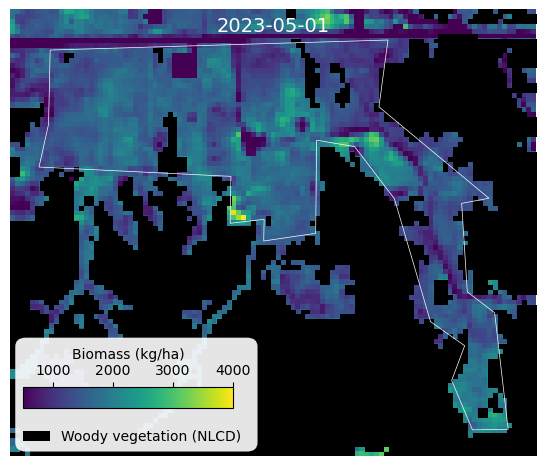

In [35]:
# create figure and axis with automatic size based on pixels/inch set above
fig, ax = plt.subplots(figsize=(len(xr_all.x)/pixpi_out, len(xr_all.y)/pixpi_out), layout='constrained')
# turn off axis on map
ax.axis('off')
# plot the image for the first date
im = show(xr_all.sel(date=dates[0])['biomass_kg_ha'].data, vmin=500, vmax=4000, animated=True,
              transform=xr_all.rio.transform(), ax=ax)
# get the image object for the legend
im_for_legend = im.get_images()[0]
# plot the NLCD mask
show(xr_nlcd_mask.data, animated=True, transform=xr_nlcd_mask.rio.transform(), ax=ax, cmap='gray')
# plot the boundar of the aoi
gdf_aoi.boundary.plot(ax=ax, edgecolor='white', linewidth=0.5)
# annotate with text for the date
date_text = ax.text(0.5, 0.95, 
                    dates[0].dt.floor('D').dt.strftime("%Y-%m-%d").values,
                    c='white', size=14, horizontalalignment='center', fontweight=500,
                    transform=ax.transAxes, animated=True)

# legend stuff
# create a bounding box for the legend
bb = mtransforms.Bbox([[0.1, 0.1], [0.38, 0.175]])
# make the bounding box 'fancy' with rounded corners and some transparency
fancy = FancyBboxPatch(bb.p0, bb.width, bb.height, boxstyle="round,pad=0.09,rounding_size=0.02",
                       fc='white', ec='none', alpha=0.9, transform=ax.transAxes)
# add the box to the axis
ax.add_patch(fancy)
# create a custom legend patch for the NLCD mask (a black box)
legend_elements = [Patch(facecolor='black', edgecolor='none',
                         label='Woody vegetation (NLCD)')]
# create the lengend from the custom patch
ax.legend(handles=legend_elements, loc='lower left', framealpha=0.0)
# create a colorbar for the map
cb = fig.colorbar(im_for_legend, ax=ax, orientation='horizontal', 
             shrink=0.4,  label='Biomass (kg/ha)',
             aspect=10, pad=-0.22,
             anchor=(0.04, 1.0))# fraction=0.026, pad=0.04)
# flip the axis ticks and label of the colorbar to be on top
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")

In [36]:
# function to update data during animation
def animate_xr_ts(frame):
    im.images[0].set_data(xr_all.sel(date=dates[frame])['biomass_kg_ha'].data)
    date_text.set_text(dates[frame].dt.floor('D').dt.strftime("%Y-%m-%d").values)
    return (im, date_text)

# create the animation
ani = animation.FuncAnimation(fig, animate_xr_ts, interval=200,
                              frames=len(dates), repeat=True, repeat_delay=1000)

# specify how to write the output, including frames per second (fps)
writer = animation.PillowWriter(fps=len(dates)//duration_secs)

# save the animation to disk
ani.save(os.path.join(outDIR, 'ffar_ok_bm_kgha_anim_' + str(yr) + '.gif'),
         dpi=150, #50
         writer=writer,
         savefig_kwargs={'transparent': True, 'pad_inches': 0},
         progress_callback=lambda i, n: print(f'Saving frame {i+1} of {n}', end='\r'))

### Create and save single year gif with timeseries line plot for custom area

In [37]:
from shapely.geometry import Polygon
import matplotlib.dates as mdates
import pandas as pd
import geopandas as gpd
from rasterio.plot import show

In [38]:
# manually create the two AOI's (used the approx bounds of two of the tower sites GPS coords)
aoi1 = gpd.GeoSeries(Polygon(((662905.13, 3756330.15),
                              (662903.43, 3756409.31),
                              (663003.76, 3756411.85),
                              (663005.45, 3756331.84))))
aoi2 = gpd.GeoSeries(Polygon(((663921.09, 3755925.03),
                              (663919.82, 3756005.46),
                              (664021.41, 3756007.58),
                              (664020.57, 3755926.30))))

In [39]:
# create empty time series for AOI 1 equal to the length of the dates vector
ts_bm1 = np.array(np.repeat(np.nan, len(dates)))
# fill the first value of the time series with the mean from the AOI on the first date
ts_bm1[0] = xr_all.sel(date=dates[0], 
                      x=slice(aoi1.total_bounds[0], aoi1.total_bounds[2]),
                      y=slice(aoi1.total_bounds[3], aoi1.total_bounds[1]))['biomass_kg_ha'].mean().data
# create a full time series values with all the dates
ts_bm1_all = xr_all.sel(date=slice(dates[0], dates[-1]),
                       x=slice(aoi1.total_bounds[0], aoi1.total_bounds[2]),
                       y=slice(aoi1.total_bounds[3], aoi1.total_bounds[1]))['biomass_kg_ha'].mean(dim=['y', 'x']).data

In [40]:
# create empty time series for AOI 1 equal to the length of the dates vector
ts_bm2 = np.array(np.repeat(np.nan, len(dates)))
# fill the first value of the time series with the mean from the AOI on the first date
ts_bm2[0] = xr_all.sel(date=dates[0], 
                      x=slice(aoi2.total_bounds[0], aoi2.total_bounds[2]),
                      y=slice(aoi2.total_bounds[3], aoi2.total_bounds[1]))['biomass_kg_ha'].mean().data
# create a full time series values with all the dates
ts_bm2_all = xr_all.sel(date=slice(dates[0], dates[-1]),
                       x=slice(aoi2.total_bounds[0], aoi2.total_bounds[2]),
                       y=slice(aoi2.total_bounds[3], aoi2.total_bounds[1]))['biomass_kg_ha'].mean(dim=['y', 'x']).data

In [41]:
# month-only formatter for x-axis on time series plot
myFmt = mdates.DateFormatter('%b')

In [42]:
# get the date values for the time series plot
ts_dates = np.array([pd.to_datetime(x.values.item().isoformat()).to_pydatetime() for x in dates])

In [43]:
# reset the number of pixels per inch in the figure
pixpi_out = 10

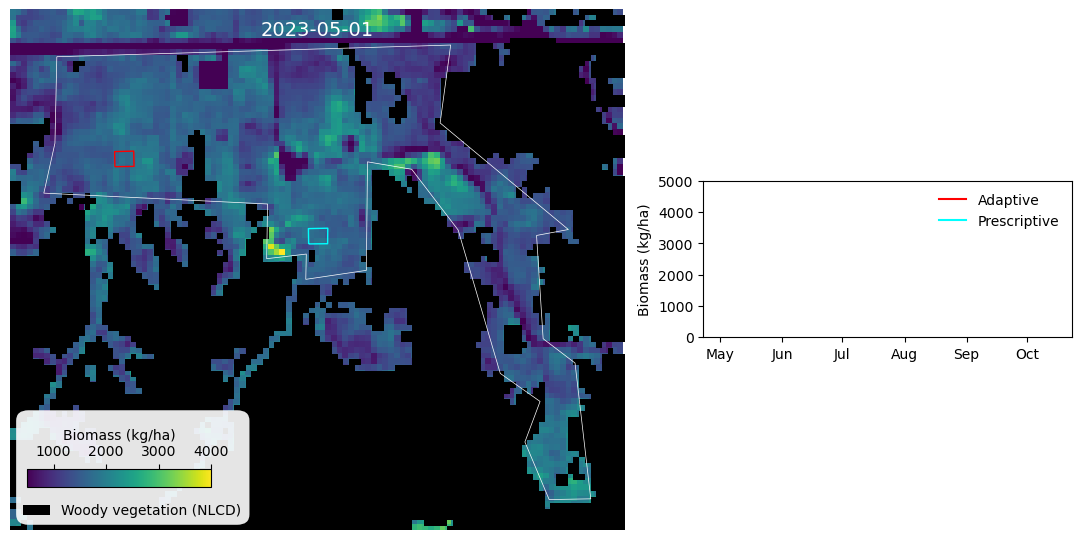

In [44]:
# create figure and axis with automatic size based on pixels/inch set above, adjusting for additional subplot
fig = plt.figure(figsize=(len(xr_all.x)/pixpi_out, (len(xr_all.y)/pixpi_out)*0.6), layout='constrained')
# create the gridspec for multiple rows/columns to be able to center subplot
gs = fig.add_gridspec(3, 3, width_ratios=[1.0, 0.01, 0.6])

# create the map axis spanning all rows of gridspec
ax1 = fig.add_subplot(gs[:, 0])
# center the map PROBABLY NOT NEEDED
ax1.set_anchor('C')
# turn off the axis ticks/labels on the map
ax1.axis('off')
# create the map
im = show(xr_all.sel(date=dates[0])['biomass_kg_ha'].data, vmin=500, vmax=4000, animated=True,
              transform=xr_all.rio.transform(), ax=ax1)
# get the image from the map
im_for_legend = im.get_images()[0]
# overlay the mask
show(xr_nlcd_mask.data, animated=True, transform=xr_nlcd_mask.rio.transform(), ax=ax1, cmap='gray')
# plot the ranch boundary
gdf_aoi.boundary.plot(ax=ax1, edgecolor='white', linewidth=0.5)
# plot the two AOI's defined above
aoi1.boundary.plot(ax=ax1, edgecolor='red', linewidth=1)
aoi2.boundary.plot(ax=ax1, edgecolor='cyan', linewidth=1)
# add the text annotation for the date
date_text = ax1.text(0.5, 0.95, 
                    dates[0].dt.floor('D').dt.strftime("%Y-%m-%d").values,
                    c='white', size=14, horizontalalignment='center', fontweight=500,
                    transform=ax1.transAxes, animated=True)

# legend stuff for map
# create a bounding box for the legend
bb = mtransforms.Bbox([[0.1, 0.1], [0.3, 0.14]])
# make the bounding box 'fancy' with rounded corners and some transparency
fancy = FancyBboxPatch(bb.p0, bb.width, bb.height, boxstyle="round,pad=0.09,rounding_size=0.02",
                       fc='white', ec='none', alpha=0.9, transform=ax1.transAxes)
# add the box to the axis
ax1.add_patch(fancy)
# create a custom legend patch for the NLCD mask (a black box)
legend_elements1 = [Patch(facecolor='black', edgecolor='none',
                         label='Woody vegetation (NLCD)')]
# create the lengend from the custom patch
ax1.legend(handles=legend_elements1, loc='lower left', framealpha=0.0)
# create a colorbar for the map
cb = fig.colorbar(im_for_legend, ax=ax1, orientation='horizontal', 
             shrink=0.3,  label='Biomass (kg/ha)',
             aspect=10, pad=-0.17,
             anchor=(0.04, 1.0))
# flip the axis ticks and label of the colorbar to be on top
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")

# create the subplot axis for the timeseries in the okddle row of the third column
ax2 = fig.add_subplot(gs[1, 2])
# anchor to center PROBABLY NOT NEEDED
ax2.set_anchor('C')
# create invisible plot with all dates and data for aoi1 to get the axis liokts right
ax2.plot(ts_dates, ts_bm1_all, linewidth=0)
# plot the first date for each AOI
ts1 = ax2.plot(ts_dates, ts_bm1, color='red', label='Adaptive')
ts2 = ax2.plot(ts_dates, ts_bm2, color='cyan', label='Prescriptive')
# manually set the liokt for the y axis
ax2.set_ylim((0, 5000))
# manually set the label for the y axis
ax2.set_ylabel('Biomass (kg/ha)')
# format the dates on the x axis
ax2.xaxis.set_major_formatter(myFmt)
# add the legend to the subplot
ax2.legend(loc='upper right', framealpha=0.0)

In [45]:
def animate_xr_ts_aoi(frame):
    im.images[0].set_data(xr_all.sel(date=dates[frame])['biomass_kg_ha'].data)
    date_text.set_text(dates[frame].dt.floor('D').dt.strftime("%Y-%m-%d").values)
    ts1[0].set_ydata(np.concatenate((ts_bm1_all[:frame], ts_bm1[frame:])))
    ts2[0].set_ydata(np.concatenate((ts_bm2_all[:frame], ts_bm2[frame:])))
    return (im, date_text, ts1, ts2)

ani = animation.FuncAnimation(fig, animate_xr_ts_aoi, interval=200,
                              frames=len(dates), repeat=True, repeat_delay=1000)

writer = animation.PillowWriter(fps=len(dates)//duration_secs)
ani.save(os.path.join(outDIR, 'ffar_ok_bm_kgha_anim_' + str(yr) + '_aois_example.gif'), 
         dpi=150,
         writer=writer,
         savefig_kwargs={'transparent': True, 'pad_inches': 0},
         progress_callback=lambda i, n: print(f'Saving frame {i+1} of {n}', end='\r'))